### CONFIGURATION

In [88]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 3000)
pd.set_option('display.width', 200)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#PYFAIDX
from pyfaidx import Fasta
genes = Fasta('/Users/peterpriestley/hmf/data/refgenomes/Homo_sapiens.GRCh37.GATK.illumina/Homo_sapiens.GRCh37.GATK.illumina.fasta')

In [3]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn
import chromosomeDefinition as cd

In [80]:
#VCF
VCF_PATH = "/Users/peterpriestley/hmf/analyses/CPCT02040055/"
# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_NON_BED_MUTATIONS = True

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [66]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [67]:
# SPECIFY SAMPLES
VCF_SAMPLES=[]
for x in os.listdir(VCF_PATH):
    if x[-10:] == "melted.vcf":
        VCF_SAMPLES.append(x)
#VCF_SAMPLES=VCF_SAMPLES[1:]
print VCF_SAMPLES

['CPCT02040055R_CPCT02040055T_merged_somatics_annotated_melted.vcf']


<h3> LOAD VCF

In [68]:
for VCF_SAMPLE in VCF_SAMPLES:
      print VCF_SAMPLE[0:VCF_SAMPLE.find("_")]

CPCT02040055R


In [82]:
#Load all VCF_SAMPLES to DF
df = pd.DataFrame({})
for VCF_SAMPLE in VCF_SAMPLES:
    VCF_FILE_NAME = VCF_SAMPLE
    SAMPLE_NAMES = {VCF_SAMPLE[0:12]+"T":'melted'}
    #SAMPLE_NAMES = {VCF_SAMPLE[11:27:'melted'}
    #SAMPLE_NAMES = {"/sample/output/160604_HMFreg0056_FR10302029_FR10302030_CPCT02010299/somaticVariants/CPCT02010299R_CPCT02010299T/CPCT02010299R_CPCT02010299T_merged_somatics_snpEff_dbSNP_Cosmicv76":'melted'}
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[0:VCF_SAMPLE.find("_")],True,True,bed,LOAD_NON_BED_MUTATIONS)])
        #df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,{'CPCT02070011T':'melted'},"CPCT02070011",True,True,bed,LOAD_NON_BED_MUTATIONS)])
    else:
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[0:VCF_SAMPLE.find("_")],True)])

reading vcf file: CPCT02040055R_CPCT02040055T_merged_somatics_annotated_melted.vcf
reading VCF File line: 1
Number variants loaded: 66088


In [ ]:
df = loadHealthChecksAndMerge(df)

### PON FILTERING

In [33]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [34]:
#dfPON = aVCF.loadPON("/Users/peterpriestley/hmf/analyses/PON/","PON.tsv")
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")


In [35]:
df['alt'] = df['meltedallele']
df = pd.merge(df,dfPON,how='left', on=['chrom','pos','ref','alt'])
df['PONCount'].fillna(0, inplace=True)
df['inPON'] = pd.to_numeric(df.PONCount,errors=coerce)>4

In [68]:
#del df['PONCount']
#del df['inPON']

In [89]:
df[(df.consensus==True)&(df.numCallers==2)][['chrom','pos']]

,chrom,pos
47,1,1257286
50,1,1395449
75,1,2000138
137,1,2891239
138,1,2914269
152,1,3689115
161,1,4133380
181,1,4911684
182,1,4977396
188,1,5164124


In [83]:
#df['inPON'] = pd.to_numeric(df.PONCount,errors=coerce)>=4
pd.pivot_table(df, values='pos', index=['patientName','numCallers','bedRegion'], columns=['consensus'], aggfunc='count',margins=False).fillna("")

consensus                           False True 
patientName   numCallers bedRegion             
CPCT02040055R 1                     31967      
                         Default    14101      
              2                      2218  1303
                         Default     3025  1658
              3                             475
                         Default           1118
              4                             826
                         Default           9397

<h3> VAF

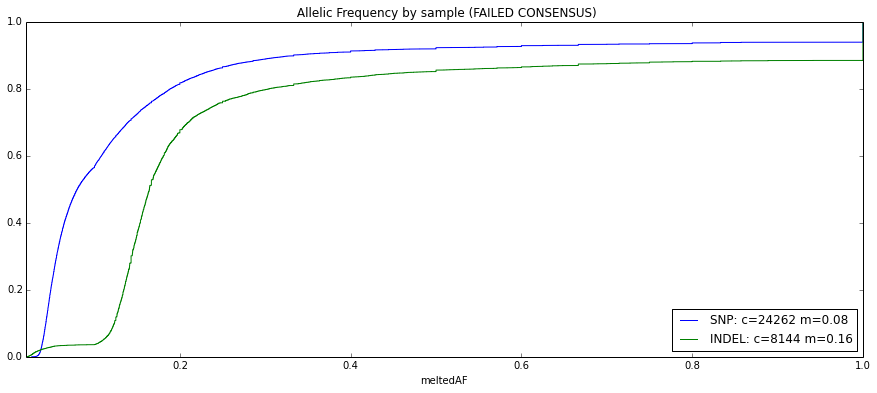

In [49]:
for variantType in ['SNP','INDEL']:
    ser = df[(df['consensus']==False)&(df['inDBSNP']==False)&(df.variantType==variantType)]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=variantType+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by sample (FAILED CONSENSUS)",figsize=[15,6])

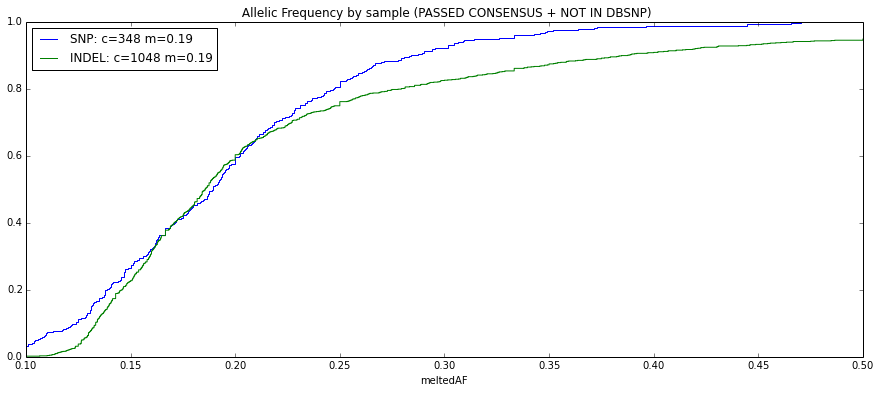

In [31]:
for variantType in ['SNP','INDEL']:
    ser = df[(df['consensus']==True)&(df.variantType==variantType)]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=variantType+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by sample (PASSED CONSENSUS + NOT IN DBSNP)",figsize=[15,6],xlim=[0.1,0.5])

In [ ]:
pd.pivot_table(df[(df.variantType=='SNP')&(df.meltedallele.str.len()==1)&(df.meltedAF<0.07)&(df.consensus==True)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

### HIGH and MODERATE impact NON-missense

In [ ]:
#pd.pivot_table(df, values='pos', index=['chromPos','patientName','TUMOR_TYPE','annGene','annWorstImpact','annWorstEffect','consensus','meltedAF'], columns=['inCOSMIC'], aggfunc='count',margins=True).fillna("")

### Missense

In [13]:
#df[((df.annWorstImpact=="HIGH")|(df.annWorstImpact=="MODERATE"))&(df.consensus==True)]

In [14]:
#df[(df.annAllEffects.str.contains("missense"))]

In [ ]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))], values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

In [ ]:
pd.pivot_table(df, values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

In [ ]:
len(df[(df.annAllEffects.str.contains("missense"))&(df.bedRegion <> '')])

### Consensus

In [ ]:
pd.pivot_table(df[(df.consensus==True)&((df.annWorstImpact=="HIGH")|(df.annWorstImpact=="MODERATE"))], values='pos', index=['annGene'], columns=['patientName'], aggfunc='count',margins=True).fillna("").sort_values("All",ascending=False)

### Mutational Patterns

In [61]:
pd.pivot_table(df[(df.ref.str.len()==1)&(df.variantType == 'SNP')&(df.consensus == True)&(df.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,77,191,134,402.0
C,272,,115,469,856.0
G,458,95,,265,818.0
T,138,192,79,,409.0
All,868,364,385,868,2485.0


In [ ]:
pd.pivot_table(df[df.annAllEffects.str.contains("missense")], values='pos', index=['chromPos','patientName','annGene','meltedAF','numCallers','inCOSMIC'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SINGLE PATIENT ANALYSIS

In [ ]:
df[(df.patientName=='CPCT02140013')]#[['patientName','TUMOR_TYPE','pos','chrom','id','variantType','ref','meltedallele','meltedDP','meltedAF','vennSegment','annGene']].head(20)

### SCRATCH

In [ ]:
pd.pivot_table(df, values='pos', index=['numCallers','vennSegment'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

In [ ]:
df[df.numCallers ==1]

In [ ]:
def refgenomeContext(chromPos):
    chrom = chromPos.split(':')[0]
    pos = int(chromPos.split(':')[1])
    try:
        return str(genes[chrom][pos-2:pos+1][:3])
    except TypeError:
        return -1

In [ ]:
refgenomeContext('7:467652')

In [ ]:
df['refTriplet'] =df['chromPos'].apply(lambda x: refgenomeContext(x))

In [ ]:
df.head(1)

In [ ]:
pd.pivot_table(df[df.variantType=='SNP'], values='pos', index=['refTriplet','meltedallele'], columns=['inDBSNP'], aggfunc='count',margins=True).fillna("").sort_values('All',ascending=False)

### VENN

In [ ]:
dftemp = df[(df.consensus== True)&(df.variantType == "SNP")&(df.annAllEffects.str.contains('missense'))&(df.inPON==False)]
vn.venn([dftemp[dftemp.patientName == 'PMC010001T']['chromPos'],dftemp[dftemp.patientName == 'PMC010001TII']['chromPos'], \
        dftemp[dftemp.patientName == 'PMC010001TIII']['chromPos']],['PMC010001T','PMC010001TII','PMC010001TIII'],figsize=(9,9))

### Common mutations

In [ ]:
len(df)

In [ ]:
# Calls with more than 1 instance
dfTemp = df[['consensus','inPON','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','chromPos','id']].groupby(['inPON','consensus','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','id']).agg('count').sort_values('chromPos',ascending=False)
dfTemp = dfTemp[dfTemp.chromPos>1]
len(dfTemp)

In [ ]:
#dfTemp = pd.pivot_table(df[(df.bedRegion=='Default')], values='chromPos', index=['chrom','pos','annGene','annWorstEffect','id'], columns=['bedRegion'], aggfunc='count',margins=True).fillna("")
#dfTemp = dfTemp[dfTemp.All>1].sort_values('All',ascending=False)
#len(dfTemp)

In [ ]:
dfTemp = dfTemp.reset_index()

In [ ]:
dfTemp[(dfTemp.consensus==True)][['inPON','variantType','numCallers','chromPos']].groupby(['inPON','variantType','numCallers']).agg('count')  #.reset_index().sort_values('numCallers',ascending=False)

In [ ]:
dfTemp
dfTemp.groupby(['TUMOR_TYPE']).agg('count')['patientName']

In [ ]:
#temp.reset_index
#groupby(['bedRegion']).agg('count')

In [ ]:
temp.sort_values('All',ascending=False)

In [ ]:
pd.pivot_table(df, values='pos', index=['annWorstEffect'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SOMATIC AF

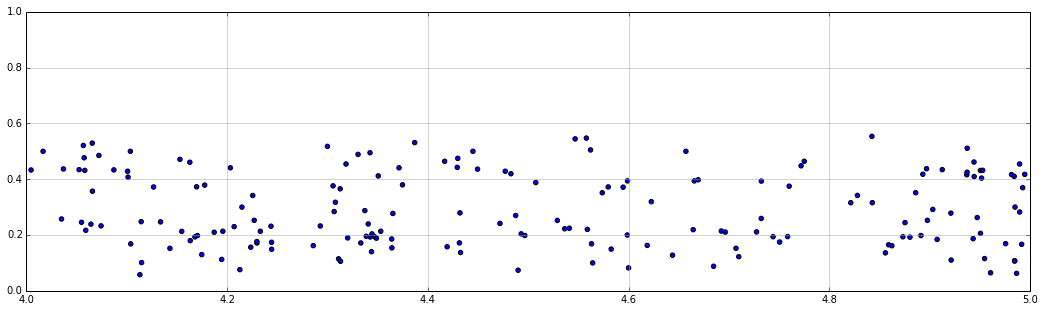

In [63]:
############### SOMATIC AF ##############
c = 4
fractionMin = 0
fractionMax = 1
dfSom = df[(df['variantType']=="SNP")&(df['consensus']==True)&(df['inPON']==False)&(df.chromFrac>c+fractionMin)&(df.chromFrac<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromFrac, dfSom.meltedAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

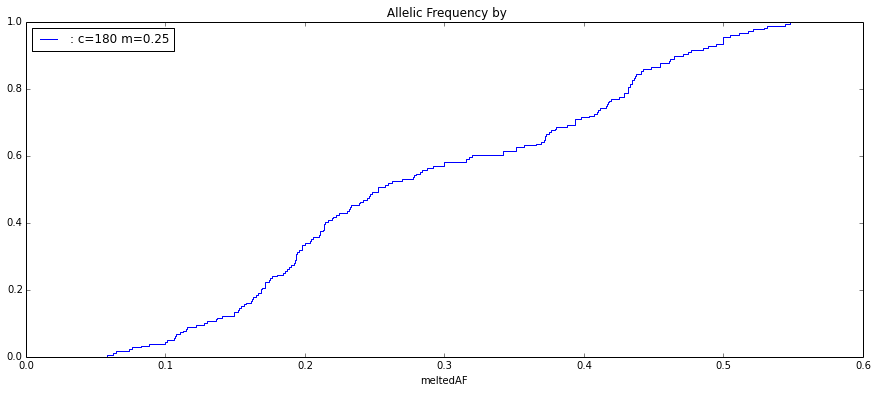

In [64]:
ser = dfSom[(dfSom.chromFrac>3.4)&((dfSom.chromFrac>1.75))].meltedAF
ser = ser.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.6])

### COPY NUM vs SOMATIC AF

In [ ]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [ ]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss']
CNV_PATH="/Users/peterpriestley/hmf/analyses/CPCT02140029/"
CNV_FILENAMES=[]
for x in os.listdir(CNV_PATH):
    if x[-9:] == ".bam_CNVs":
        CNV_FILENAMES.append(x)
CNV_FILENAMES

In [ ]:
def calculateCopyNumForVariant(chromosome,position):
    return dfCNV[(dfCNV.chrom==chromosome)&(dfCNV.posStart<position)&(dfCNV.posEnd>=position)]['copyNum'].mean()

In [ ]:
for filename in CNV_FILENAMES:
    patientName=filename[:12]
    dfCNV = loadCNVforPatient(CNV_PATH+filename,patientName)

In [ ]:
df.head(1)

In [ ]:
#df['intchrom']=
df['copyNum']=np.vectorize(calculateCopyNumForVariant)( df['chrom'].apply(lambda x: cd.intChrom(x)),(df.pos))

### SCRATCH